In [1]:
# !pip install transformers
!pip install datasets
!pip install seqeval
!pip install accelerate -U
# !pip install transformers[torch]
# !pip install uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
# Load your data

from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv("/content/drive/MyDrive/train.csv",encoding="utf-8" )
test_data = pd.read_csv("/content/drive/MyDrive/test.csv",encoding="utf-8" )


Mounted at /content/drive


In [4]:
# Convert the tags to unique ids
unique_tags = train_data['Tag'].unique().tolist()
tag2id = {tag: idx for idx, tag in enumerate(unique_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

# Set a fixed sequence length
SEQ_LEN = 75

In [5]:
def create_sequences(data, seq_len=SEQ_LEN):
    words = data['Word'].tolist()
    tags = data['Tag'].tolist()

    sequences = []
    labels = []
    for i in range(0, len(words), seq_len):
        seq_words = words[i:i+seq_len]
        seq_tags = tags[i:i+seq_len]

        if len(seq_words) < seq_len:
            seq_words += ['[PAD]'] * (seq_len - len(seq_words))
            seq_tags += ['O'] * (seq_len - len(seq_tags))

        sequences.append(seq_words)
        labels.append([tag2id[tag] for tag in seq_tags])

    return sequences, labels

In [6]:
train_sequences, train_labels = create_sequences(train_data)
test_sequences, test_labels = create_sequences(test_data)

# Split training data into train and validation sets
train_sequences, val_sequences, train_labels, val_labels = train_test_split(train_sequences, train_labels, 
                                                            test_size=0.2, random_state=42)

In [7]:
# Convert to Hugging Face Dataset format
from datasets import Dataset
from datasets import Dataset, DatasetDict

def create_dataset(sequences, labels):
    return Dataset.from_dict({'tokens': sequences, 'labels': labels})

train_dataset = create_dataset(train_sequences, train_labels)
val_dataset = create_dataset(val_sequences, val_labels)
test_dataset = create_dataset(test_sequences, test_labels)

datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [8]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments
from datasets import DatasetDict, load_metric

In [9]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, padding='max_length', max_length=SEQ_LEN, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if word_id is None else label[word_id] for word_id in word_ids]
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

In [95]:
# Define the model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(tag2id))

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=8,    # Adjust batch size as needed,8
    per_device_eval_batch_size=8,     # Adjust batch size as needed,8
    num_train_epochs=20,              # 6,10
    gradient_accumulation_steps=4,    # Accumulate gradients over 4 steps
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=10,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [96]:
# Metric for evaluation
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2tag[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [97]:
# Lists to store training and evaluation metrics
train_accuracies = []
eval_accuracies = []
train_losses = []
eval_losses = []

def record_metrics_callback(state):
    if state.is_local_process_zero:
        # Record training loss
        if 'loss' in state.log_history[-1]:
            train_losses.append(state.log_history[-1]['loss'])
        # Record evaluation loss and accuracy
        if 'eval_loss' in state.log_history[-1]:
            eval_losses.append(state.log_history[-1]['eval_loss'])
            eval_accuracies.append(state.log_history[-1]['eval_accuracy'])

# Custom Trainer class to record metrics
class CustomTrainer(Trainer):
    def log(self, logs: dict):
        super().log(logs)
        record_metrics_callback(self.state)

In [98]:
# Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
)
torch.cuda.empty_cache()

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,1.085231,0.280000,0.165354,0.207921,0.372280
2,0.935500,0.841235,0.054913,0.149606,0.080338,0.657131
4,0.580500,0.602308,0.151351,0.220472,0.179487,0.757454
6,0.478400,0.739419,0.478261,0.259843,0.336735,0.792103
8,0.281400,0.916756,0.507042,0.283465,0.363636,0.808824
10,0.259700,0.815388,0.333333,0.251969,0.286996,0.785254
12,0.199700,1.144855,0.397727,0.275591,0.325581,0.790089
14,0.230800,1.265842,0.354167,0.267717,0.304933,0.749396
16,0.242000,0.818556,0.400000,0.251969,0.309179,0.814666
18,0.191800,0.859227,0.560606,0.291339,0.383420,0.815068


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


TrainOutput(global_step=160, training_loss=0.4161402717232704, metrics={'train_runtime': 89.3141, 'train_samples_per_second': 60.013, 'train_steps_per_second': 1.791, 'total_flos': 193218450181200.0, 'train_loss': 0.4161402717232704, 'epoch': 18.823529411764707})

In [99]:
# Evaluate the model
eval_results = trainer.evaluate()

In [100]:
print('Precision: ', eval_results['eval_precision'])
print('Recall: ', eval_results['eval_recall'])
print('F1: ', eval_results['eval_f1'])
print('Accuracy: ', eval_results['eval_accuracy'])

Precision:  0.5606060606060606
Recall:  0.29133858267716534
F1:  0.383419689119171
Accuracy:  0.815068493150685


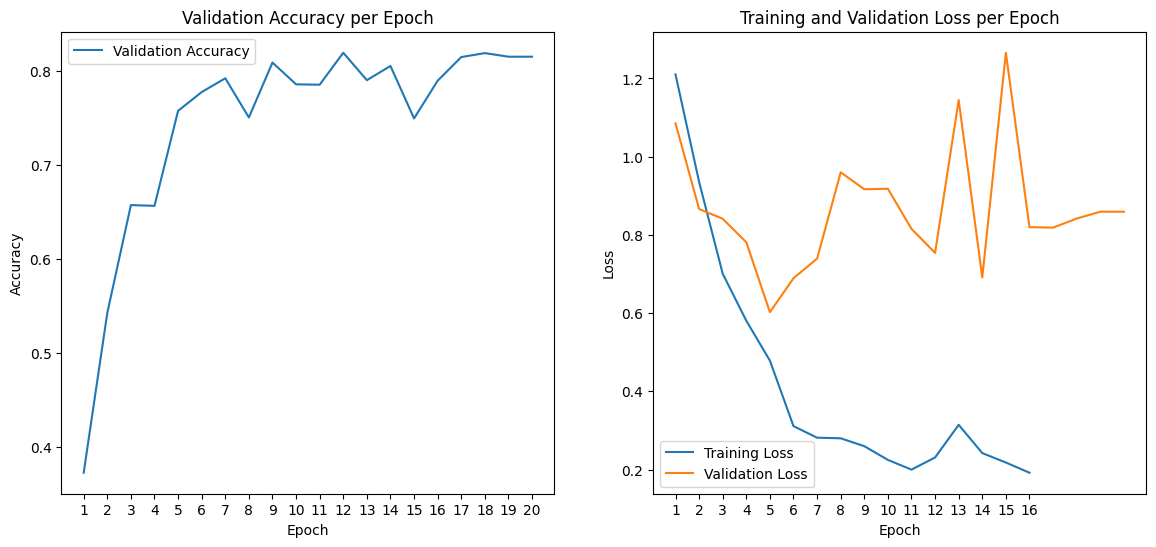

In [101]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_accuracies) + 1), eval_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(eval_accuracies) + 1))
plt.legend()
# plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
# plt.grid(True)

# plt.tight_layout()
plt.show()

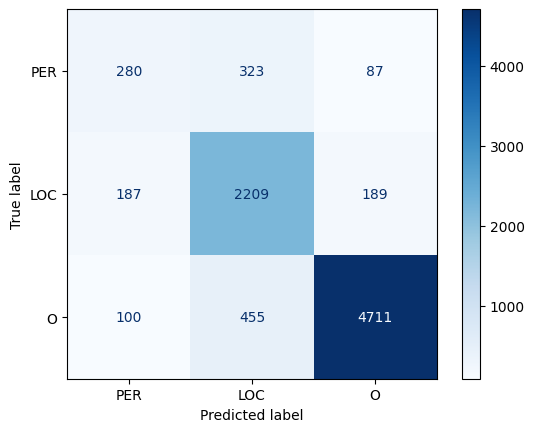

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
predictions, labels, _ = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(predictions, axis=2)

# Flatten the predictions and labels for confusion matrix
flat_predictions = [p for preds in predictions for p in preds if p != -100]
flat_labels = [l for label in labels for l in label if l != -100]

# Generate confusion matrix
cm = confusion_matrix(flat_labels, flat_predictions[0:8541], labels=list(tag2id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(tag2id.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()